In [1]:
from sklearn.decomposition import NMF, PCA

from keras.models import Model
import keras.models
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K

import copy
import cnn_analyzer as cnna
import cnn_builder as cbuild
import config
import csv
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import importlib
import itertools
from math import sqrt, log, pi, exp
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import operator
import os
from os.path import *
import pandas as pd
import random
import scipy
from scipy.optimize import minimize
import time
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()

In [3]:
model = keras.models.load_model(os.path.join(C.model_dir, "model_no_pad.hdf5"))

In [117]:
model = keras.models.load_model(os.path.join(C.model_dir, "model_skipcon.hdf5"))

In [ ]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305

In [1406]:
pca = PCA()
all_c3_tr = pca.fit_transform(all_conv3_ch)
pca.singular_values_

In [135]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [206]:
model_conv7 = cbuild.build_pretrain_model(model, padding=['same','same'], pool_sizes = [(2,2,2),(2,2,2)],
                                              f=[64,64,64,64,64,64,64], skip_con=True, last_layer=-5)

In [4]:
#model_conv1_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-6)#, add_activ=True)
#model_conv2_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-5)#, add_activ=True)
model_conv3_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-4)
#model_dense_pre = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-3)#, add_activ=True)

In [5]:
model_conv3 = cbuild.build_pretrain_model(model, padding=['same','same'], last_layer=-4, add_activ=True)

In [18]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

features_by_cls, feat_count = cnna.collect_features()
#feat_count.pop("central scar")
all_features = sorted(list(feat_count.keys()))
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls)
#Z_features.pop("central scar")

num_features = len(all_features)

In [7]:
import dr_methods as drm
voi_df = drm.get_voi_dfs()[0]

In [19]:
Z = np.concatenate([orig_data_dict[cls][1] for cls in C.classes_to_include], 0)
aug_factor = 10

#all_conv2_ch = np.empty([0,128])
#all_conv3_ch = np.empty([0,128])
all_conv3_ch = np.empty([aug_factor*len(Z),12,12,6,128])

for img_id in range(len(Z)):
    voi_row = voi_df.loc[Z[img_id]]
    for aug_id in range(aug_factor):
        img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z[img_id], aug_id)))
        activ = model_conv3_pre.predict(np.expand_dims(img, 0))
        #all_conv3_ch = np.concatenate([all_conv3_ch, activ.mean(axis=(1,2,3))], axis=0)
        all_conv3_ch[img_id*aug_factor+aug_id] = activ
        #all_conv3_ch = np.concatenate([all_conv3_ch, activ], axis=0)

D = np.empty((8,8,4))
for x in range(D.shape[0]):
    for y in range(D.shape[1]):
        for z in range(D.shape[2]):
            D[x,y,z] = (D.shape[0]-.5-x)**2 + (D.shape[1]-.5-y)**2 + 4*(D.shape[2]-.5-z)**2

def get_shells(activ, D):
    shell4 = activ[0, D > 85, :].mean(axis=0)
    shell3 = activ[0, (D <= 85) & (D > 62), :].mean(axis=0)
    shell2 = activ[0, (D <= 62) & (D > 39), :].mean(axis=0)
    shell1 = activ[0, D <= 39, :].mean(axis=0)
    return np.expand_dims(np.stack([shell1, shell2, shell3, shell4], 0), 0)

feature_conv3_ch['central scar'] =np.empty([0,12,12,6,128])

In [ ]:
aug_factor = 80
num_annot = 10
#feature_conv1_ch = {f:np.empty([0,12,12,6,64*3]) for f in all_features}
#feature_conv2_ch = {f:np.empty([0,12,12,6,128]) for f in all_features}
feature_conv3_ch = {f:np.empty([aug_factor*num_annot,12,12,6,128]) for f in all_features}
#feature_conv3_sh = {f:np.empty([0,4,128]) for f in all_features}
for f_ix in range(num_features):#relevant_features:
    f = all_features[f_ix]
    Z_f = Z_features[f]
    for img_id in range(len(Z_f)):
        voi_row = voi_df.loc[Z_f[img_id]]
        for aug_id in range(aug_factor):
            img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z_f[img_id], aug_id)))
            #activ = model_conv1_pre.predict(np.expand_dims(img, 0))
            #activ = np.expand_dims(tr.scale3d(activ[0], (.5,.5,.5)),0)
            #feature_conv1_ch[f] = np.concatenate([feature_conv1_ch[f], activ], axis=0)
            #activ = model_conv2_pre.predict(np.expand_dims(img, 0))
            #feature_conv2_ch[f] = np.concatenate([feature_conv2_ch[f], activ], axis=0)
            activ = model_conv3_pre.predict(np.expand_dims(img, 0))
            feature_conv3_ch[f][img_id*aug_factor+aug_id] = activ
            #feature_conv3_ch[f] = np.concatenate([feature_conv3_ch[f], activ], axis=0)
            #feature_conv3_sh[f] = np.concatenate([feature_conv3_sh[f], get_shells(activ, D)], axis=0)

In [209]:
num_channels = 128
aug_factor = 80
num_annot = 10
f_conv7_ch = {f:np.empty([aug_factor*num_annot,12,12,6,num_channels]) for f in all_features}
for f_ix in range(num_features):#relevant_features:
    f = all_features[f_ix]
    Z_f = Z_features[f]
    for img_id in range(len(Z_f)):
        voi_row = voi_df.loc[Z_f[img_id]]
        for aug_id in range(aug_factor):
            img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z_f[img_id], aug_id)))
            activ = model_conv7.predict(np.expand_dims(img, 0))
            f_conv7_ch[f][img_id*aug_factor+aug_id] = activ

In [210]:
for f_ix in range(num_features):
    f = all_features[f_ix]
    f_conv7_ch[f] = f_conv7_ch[f].mean(0)

In [21]:
conv3_ch_plus = copy.deepcopy(feature_conv3_ch)
for f_ix in range(num_features):
    f = all_features[f_ix]
    conv3_ch_plus[f][conv3_ch_plus[f] < 0] = 0
    conv3_ch_plus[f] = conv3_ch_plus[f].mean(0)

In [67]:
all_conv3_plus = copy.deepcopy(all_conv3_ch)
all_conv3_plus[all_conv3_plus < 0] = 0
#all_conv3_plus = all_conv3_plus.mean(0)

# Feature ID

In [27]:
Z_test = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

In [28]:
num_features = len(all_features) # number of features
num_annotations = 10

all_imgs = [orig_data_dict[cls][0] for cls in C.classes_to_include]
all_imgs = np.array(hf.flatten(all_imgs))

all_lesionids = [orig_data_dict[cls][1] for cls in C.classes_to_include]
all_lesionids = np.array(hf.flatten(all_lesionids))

test_indices = np.where(np.isin(all_lesionids, Z_test))[0]

fixed_indices = np.empty([num_features, num_annotations])
for f_ix,f in enumerate(all_features):
    fixed_indices[f_ix, :] = np.where(np.isin(all_lesionids, random.sample(set(Z_features[f]), num_annotations)))[0]
fixed_indices = fixed_indices.astype(int)

x_test = all_imgs[test_indices]
z_test = all_lesionids[test_indices]

In [29]:
df = pd.DataFrame(columns=['true_cls', 'pred_cls'] + \
            [s for i in range(1,5) for s in ['feature_%d' % i,'strength_%d' % i]])

In [47]:
m1 = all_conv3_plus.mean((0,1,2))
sig1 = all_conv3_plus.std((0,1,2))
for ch_ix in range(128):
    m1[ch_ix] = (all_conv3_plus[:,:,:,ch_ix] * gauss / np.mean(gauss)).mean()

In [30]:
info_content = np.zeros((num_features, 128))

In [53]:
gauss = cnna.get_gaussian_mask(2)

In [58]:
for f_ix in range(num_features):
    f = all_features[f_ix]
    m2 = np.zeros(128)
    sig2 = conv3_ch_plus[f].std((0,1,2))
    for ch_ix in range(128):
        m2[ch_ix] = (conv3_ch_plus[f][:,:,:,ch_ix] * gauss / np.mean(gauss)).mean()
        
    info_content[f_ix] = cnna.kl_div_norm(m1, sig1, m2, sig2, one_sided="less")

In [ ]:
all_neurons = all_conv3_ch
num_neurons = all_neurons.shape[-1]

lnZ = np.empty(num_features)
f_m = np.empty((num_features, num_neurons))
f_cov = np.empty((num_features, num_neurons, num_neurons))
for f_ix in range(num_features):
    f_neurons = np.concatenate([feature_conv1_ch[all_features[f_ix]],
                                feature_conv2_ch[all_features[f_ix]],
                                feature_conv3_ch[all_features[f_ix]],
                                feature_dense[all_features[f_ix]]], axis=1)
    f_neurons = feature_conv3_ch[all_features[f_ix]]
    f_m[f_ix] = f_neurons.mean(0)
    f_cov[f_ix] = np.cov(f_neurons.T)

    lnZ_f = -scipy.stats.multivariate_normal.logpdf(f_neurons, m, all_cov, allow_singular=True)
    adj = np.amax(lnZ_f)
    lnZ[f_ix] = np.log(np.mean(np.exp(lnZ_f - adj))) + adj

In [68]:
all_conv3_plus = all_conv3_plus.mean((1,2,3))

In [72]:
for f_ix in range(num_features):
    f = all_features[f_ix]
    conv3_ch_plus[f] = conv3_ch_plus[f].mean((1,2,3))

In [ ]:
for img_ix in range(len(z_test)):
    aug_factor = 100
    test_conv3_ch = np.empty([aug_factor,128])
    z = z_test[img_ix]
    voi_row = voi_df.loc[z]
    cls = voi_row['cls']
    row = [cls]

    x = np.expand_dims(x_test[img_ix], axis=0)
    preds = model.predict(x, verbose=False)[0]
    for pred_cls, _ in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:1]:
        row.append(pred_cls)

    p_f = np.empty(num_features)
    for aug_id in range(aug_factor):
        img = np.load(os.path.join(C.aug_dir, cls, "%s_%d.npy" % (z, aug_id)))
        activ = model_conv3.predict(np.expand_dims(img, 0))
        test_conv3_ch[aug_id] = activ.mean(axis=(1,2,3))

    test_neurons = test_conv3_ch #np.concatenate([test_conv3_ch, test_dense], axis=1) 
    #m_test = test_neurons.mean(axis=0)
    #test_cov = np.cov(test_neurons.T)
    lnZ = np.empty(num_features)
    p_f = np.empty(num_features)
    for f_ix in range(num_features): 
        f = all_features[f_ix]
        ch_indices = info_content[f_ix] > 0
        
        f_neurons = conv3_ch_plus[f][:, ch_indices]
        f_m = f_neurons.mean(0)
        f_cov = np.cov(f_neurons.T)
        
        all_neurons = all_conv3_plus[:, ch_indices]
        m = all_neurons.mean(0)
        all_cov = np.cov(all_neurons.T)
        
        lnZ_f = -scipy.stats.multivariate_normal.logpdf(f_neurons, m, all_cov, allow_singular=True)
        adj = np.amax(lnZ_f)
        lnZ[f_ix] = np.log(np.mean(np.exp(lnZ_f - adj))) + adj

        #indices = np.random.randint(0,test_neurons.shape[0], 1000)
        samp = test_neurons[:,ch_indices] #scipy.random.multivariate_normal(m_test, test_cov, size=10000)
        lnphf = scipy.stats.multivariate_normal.pdf(samp, f_m, f_cov, allow_singular=True)
        lnph = scipy.stats.multivariate_normal.pdf(samp, m, all_cov, allow_singular=True)

        adj = np.amax(lnphf - lnph)
        p_f[f_ix] = np.log(np.mean(np.exp(lnphf - lnph - adj))) + adj + lnZ[f_ix]
        
    evidence = {all_features[f_ix]: p_f[f_ix] for f_ix in range(num_features)}
    
    f1='infiltrative'
    f2='lobulated margins'
    if evidence[f1] < evidence[f2]:
        evidence.pop(f1)
    else:
        evidence.pop(f2)

    for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True)[:4]:
        row += [f, strength]
        
    df.loc[z] = row

In [86]:
df.to_csv('D:\\feature_analysis\\features_conv3ch_filtered.csv')

conv3_sh_plus = {}
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    activ = conv3_ch_plus[f]
    shell4 = activ[D > 85, :].mean(0)
    shell3 = activ[(D <= 85) & (D > 62), :].mean(0)
    shell2 = activ[(D <= 62) & (D > 39), :].mean(0)
    shell1 = activ[D <= 39, :].mean(0)
    conv3_sh_plus[f] = np.stack([shell1, shell2, shell3, shell4], 0)

feature_avgs = np.zeros((4,128))
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    feature_avgs[i] = conv3_sh_plus[f].mean(0).max(0)
    
channel_separations = np.empty((4,128))
for i in range(4):
    channel_separations[i] = np.amax(feature_avgs, 0) - feature_avgs[i]

active_neuron_ixs = np.where(h_ic_rot[0] > 0)

num_active_neurons = active_neuron_ixs[0].size

H = h_ic[h_ic > 0]
np.matmul(H, W)

In [9]:
@njit
def get_spatial_overlap(w, f_c3_ch):
    relevant_features = ch_weights.keys()
    
    ch_weights2 = np.zeros(num_rel_f,128)
    for ch in range(128):
        f_c3_ch[:,:,:,:,ch] = (f_c3_ch[:,:,:,:,ch] - np.mean(f_c3_ch[:,:,:,:,ch]))# / np.std(f_c3_ch[:,:,:,:,ch])
        
        if ch_weights[ch] > 0:
            w = np.zeros(f_c3_ch.shape[:4])
            for i in range(128):
                if ch_weights[i] > 0:
                    w += ch_weights[i] * f_c3_ch[:,:,:,:,i]
            w = w / np.sum(ch_weights)
            ch_weights2[ch] = np.sum(f_c3_ch[:,:,:,:,ch] * w)
            
    return ch_weights2

# Feature mapping

In [242]:
cls = 'fnh'
cls_img_set = orig_data_dict[cls][0]

#13010227_0 hcc
#12739056_2 crc
#E102095465_0 icc E103200384_0
#12207268_0 cyst
#13130745_0 hemangioma 12947326_0
#E104189184_0 fnh
list(orig_data_dict[cls][1]).index('E104189184_0')

48

In [244]:
#cls_activ_set = model_conv7.predict(cls_img_set)

img_id = 48
x = cls_img_set[img_id]

h_ic = [model_conv7.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]
h_ic += [model_conv7.predict(np.expand_dims(np.flipud(np.rot90(x,r)),0))[0] for r in range(4)]
h_ic += [model_conv7.predict(np.expand_dims(np.fliplr(np.rot90(x,r)),0))[0] for r in range(4)]

h_ic_rot = [np.rot90(h_ic[r], 4-r) for r in range(4)] #rotated back into original frame
h_ic_rot += [np.rot90(np.flipud(h_ic[r]), 4-r) for r in range(4,8)]
h_ic_rot += [np.rot90(np.fliplr(h_ic[r]), 4-r) for r in range(8,12)]

h_ic_rot = np.array(h_ic_rot)
test_neurons = h_ic_rot.mean(0)

In [152]:
#cls_activ_set = model_conv3_pre.predict(cls_img_set)

img_id = 83
x = cls_img_set[img_id]

h_ic = [model_conv3_pre.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]
h_ic += [model_conv3_pre.predict(np.expand_dims(np.flipud(np.rot90(x,r)),0))[0] for r in range(4)]
h_ic += [model_conv3_pre.predict(np.expand_dims(np.fliplr(np.rot90(x,r)),0))[0] for r in range(4)]

for r in range(len(h_ic)):
    h_ic[r][h_ic[r] < 0] = 0

h_ic_rot = [np.rot90(h_ic[r], 4-r) for r in range(4)] #rotated back into original frame
h_ic_rot += [np.rot90(np.flipud(h_ic[r]), 4-r) for r in range(4,8)]
h_ic_rot += [np.rot90(np.fliplr(h_ic[r]), 4-r) for r in range(8,12)]

h_ic_rot = np.array(h_ic_rot)
test_neurons = h_ic_rot.mean(0)

In [145]:
print(list(zip(range(len(all_features)), all_features)))

[(0, 'arterial enhancement'), (1, 'central scar'), (2, 'continuous enhancing rim'), (3, 'delayed isointensity'), (4, 'heterogeneous'), (5, 'homogeneous'), (6, 'hyperintense mass on delayed phase'), (7, 'hypointense without enhancement'), (8, 'infiltrative'), (9, 'lobulated margins'), (10, 'nodular or discontinuous enhancement'), (11, 'progressive centripetal filling'), (12, 'progressive uniform enhancement'), (13, 'progressive uniform enhancement (crc)'), (14, 'regular spherical hypointense mass'), (15, 'thin well-defined walls'), (16, 'venous washout')]


In [245]:
relevant_features = [1,3,0]
#[13,2,14] #colorectal, [16,0,4] #hcc, [4,9,12] #cholangio, [7,14,15] #cyst [1,3,0] #fnh # [6, 10, 11] #hemangioma
img_dir = "D:\\feature_analysis\\"+cls
if not exists(img_dir):
    os.makedirs(img_dir)

num_rel_f = len(relevant_features)
print(np.array(all_features)[relevant_features])

['central scar' 'delayed isointensity' 'arterial enhancement']


In [247]:
gauss = cnna.get_gaussian_mask(1)
feature_avgs = np.zeros((num_rel_f, num_channels))
for i, f_ix in enumerate(relevant_features):
    f = all_features[f_ix]
    for ch_ix in range(num_channels):
        feature_avgs[i, ch_ix] = (f_conv7_ch[f][:,:,:,ch_ix] * gauss / np.mean(gauss)).mean()
    #feature_avgs[i] = f_conv7_ch[f].mean((0,1,2))
    
channel_separations = np.empty((num_rel_f, num_channels)) # separation between channel mean activations for the relevant features
for i in range(num_rel_f):
    channel_separations[i] = (np.amax(feature_avgs, 0) - feature_avgs[i]) / np.mean(feature_avgs, 0)

channel_separations *= 10

W = np.zeros((num_rel_f, num_channels))
for ch_ix in range(num_channels):
    #f_ix = list(channel_separations[:,ch_ix]).index(0)
    #W[f_ix,ch_ix] = channel_separations[:,ch_ix].mean()
    W[:,ch_ix] = np.median(channel_separations[:,ch_ix]) - channel_separations[:,ch_ix]
    
W[W < 0] = 0

In [150]:
test_neurons = h_ic_rot[0]

In [167]:
def get_saliency_map(W, test_neurons, num_rel_f):
    sal_map = np.zeros((num_rel_f, *test_neurons.shape[:3]))
    for f_num in range(num_rel_f):
        for ch_ix in range(test_neurons.shape[-1]):
            sal_map[f_num] += W[f_num, ch_ix] * test_neurons[:,:,:,ch_ix]
        sal_map[f_num] /= np.sum(W[f_num])
        
    #for f_num in range(num_rel_f):
    #    for spatial_ix in np.ndindex(test_neurons.shape[:-1]):
    #        sal_map[f_num, spatial_ix] = sal_map[f_num, spatial_ix]**2 / sal_map[:, spatial_ix].sum()
            
    return sal_map

In [286]:
relevant_features

[12, 2, 13]

alpha

[3, 7, 10] = [.9,1.3,1.2] icc
[13, 0, 3] = [1,1.4,2] hcc
[12,2,13] = [1.2,.95,1.8] crc
[5, 11, 12] = [.8,1.1,1.2] cyst
[9, 4, 8] = [1.5,1.4,1.7] hem

[3, 0, 1] = ... fnh

beta
[3, 7, 10] = [1.1,1.3,1.8] icc
[13, 0, 3] = [1.8,1.1,1.2] hcc
[12,2,13] = [1.5,1.5,1.8] crc
[5, 11, 12] = [1.1,1.1,1.3] cyst
[9, 4, 8] = [1.1,1.3,1.5] hem
[2, 0, 11] = ... fnh

['central scar' 'delayed isointensity' 'arterial enhancement']


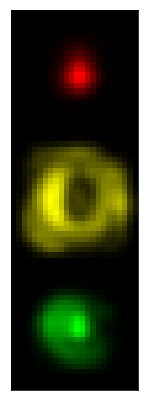

In [257]:
gauss = cnna.get_gaussian_mask(4)
z = orig_data_dict[cls][1][img_id]

bw = False
width = x.shape[0]
overlaid_img_clr = np.zeros((width*3, x.shape[1], 3))
overlaid_img = x - np.amin(x)

high_window = [1,.4,1] #relative intensity
low_window = [0.2,0.1,0.1] #relative intensity

sal_map = get_saliency_map(W, test_neurons, num_rel_f)
RGB = []
for f_num in range(num_rel_f):
    sal_map[f_num] *= gauss
    sal_map[f_num] -= sal_map[f_num].min()
    hi_thresh = sal_map[f_num].max()*high_window[f_num]
    lo_thresh = sal_map[f_num].max()*low_window[f_num]
    sal_map[f_num][sal_map[f_num] > hi_thresh] = hi_thresh
    sal_map[f_num][sal_map[f_num] < lo_thresh] = lo_thresh
    sal_map[f_num] -= sal_map[f_num].min()
    sal_map_f = tr.scale3d(sal_map[f_num], (2,2,2))
    if bw:
        sal_map_f = overlaid_img[:,:,:,f_num]
        hi_thresh = sal_map_f.max()*1
        lo_thresh = sal_map_f.max()*0.2
        sal_map_f[sal_map_f > hi_thresh] = hi_thresh
        sal_map_f[sal_map_f < lo_thresh] = lo_thresh
        sal_map_f -= sal_map_f.min()
    RGB.append(sal_map_f[:,:,sal_map_f.shape[2]//2])
    
overlaid_img_clr[:width,:,0] = RGB[0]
overlaid_img_clr[width:width*2,:,0] = overlaid_img_clr[width:width*2,:,1] = RGB[1]
overlaid_img_clr[width*2:,:,1] = RGB[2]
    
overlaid_img_clr -= overlaid_img_clr.min() - 0
overlaid_img_clr *= 1 / overlaid_img_clr.max()

if bw:
    overlaid_img_clr = overlaid_img_clr.mean(-1)
    overlaid_img_clr = np.transpose(np.tile(overlaid_img_clr, (3,1,1)), (1,2,0))

overlaid_img_clr[:width] *= 1 / overlaid_img_clr[:width].max()
overlaid_img_clr[width:width*2] *= 1 / overlaid_img_clr[width:width*2].max()
overlaid_img_clr[width*2:] *= 1 / overlaid_img_clr[width*2:].max()

fig = plt.imshow(overlaid_img_clr)
fig.get_figure().set_figheight(7)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
print(np.array(all_features)[relevant_features])

In [258]:
from skimage.transform import rescale, resize
fixed_width = 100
plt.imsave(join(img_dir, z+"_7.png"), resize(overlaid_img_clr, [fixed_width*3, fixed_width]))#(fig*255/fig.max()).astype(int))

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [86]:
plt.imsave(join(img_dir, z+"_bw.png"), resize(overlaid_img_clr, [fixed_width*3, fixed_width]))#(fig*255/fig.max()).astype(int))

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
import scipy.stats.gaussian_kde

import sklearn.

In [44]:
#model_conv1_input = cbuild.build_pretrain_model_back(model, first_layer=-5)
#model_conv2_input = cbuild.build_pretrain_model_back(model, first_layer=-4)
model_conv3_input = cbuild.build_pretrain_model_back(model, first_layer=-3)

In [ ]:
model_conv3_input = cbuild.build_pretrain_model_back(model, first_layer=-3)

In [45]:
z_bias = model_conv3_input.layers[-1].get_weights()[1]

In [ ]:
z_bias = model_conv3_input.layers[-1].get_weights()[1]

In [424]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [831]:
C.classes_to_include

['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']

In [192]:
def get_cls_sep(z, cls_num=5):
    if cls != C.classes_to_include[cls_num]:
        print("Check cls_num")
        return
    ixs = list(set(range(len(C.classes_to_include))).difference([cls_num]))
    return z[cls_num] - max(z[ixs])

In [ ]:
sal_map = get_saliency_map(W, test_neurons, num_rel_f)

z_actual = model_conv3_input.predict(np.expand_dims(test_neurons,0))[0] - z_bias

h_ja = np.zeros((num_rel_f, test_neurons.shape[-1]))
for f_num in range(num_rel_f):
    h_ja[f_num] = conv3_ch_plus[all_features[relevant_features[f_num]]].mean((0,1,2))

test_n_ch = test_neurons.mean((0,1,2))

sol = minimize(lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] + w[2]*h_ja[2] - test_n_ch)**2) - .001*(log(w[0]) + log(w[1]) + log(w[2])), [15,1,1],
         bounds = ((0.001, None), (0.001, None), (0.001, None)))
w_a = sol['x']
w_a

In [ ]:
contrib_sample = np.zeros(test_neurons.shape)
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[1]*h_ja[1, ch_ix] - w_a[2]*h_ja[2, ch_ix]
z_base = model_conv3_input.predict(np.expand_dims(contrib_sample,0))[0] - z_bias

z_onef = np.zeros((num_rel_f, 6))
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[1]*h_ja[1, ch_ix]
z_onef[2] = model_conv3_input.predict(np.expand_dims(contrib_sample,0))[0] - z_bias
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[2]*h_ja[2, ch_ix]
z_onef[1] = model_conv3_input.predict(np.expand_dims(contrib_sample,0))[0] - z_bias
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[1]*h_ja[1, ch_ix] - w_a[2]*h_ja[2, ch_ix]
z_onef[0] = model_conv3_input.predict(np.expand_dims(contrib_sample,0))[0] - z_bias

contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
for f_num in range(num_rel_f):
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]# * (sal_map[f_num] > np.median(sal_map[f_num]))

z_twof = np.empty((num_rel_f, 6))
for f_num in range(num_rel_f):
    z_twof[f_num] = model_conv3_input.predict(np.expand_dims(contrib_sample[f_num],0))[0] - z_bias

dz_actual = get_cls_sep(z_actual)
dz_base = get_cls_sep(z_base)
den = dz_actual - dz_base

C.classes_to_include

dz_0 = get_cls_sep(z_onef[0])
dz_1 = get_cls_sep(z_onef[1])
dz_2 = get_cls_sep(z_onef[2])
dz_01 = get_cls_sep(z_twof[2])
dz_02 = get_cls_sep(z_twof[1])
dz_12 = get_cls_sep(z_twof[0])

num_0 = []
num_0.append(dz_0 - dz_base)
num_0.append(dz_actual - dz_12)
num_0.append(dz_01 - dz_1)
num_0.append(dz_02 - dz_2)

num_1 = []
num_1.append(dz_1 - dz_base)
num_1.append(dz_actual - dz_02)
num_1.append(dz_01 - dz_0)
num_1.append(dz_12 - dz_2)

num_2 = []
num_2.append(dz_2 - dz_base)
num_2.append(dz_actual - dz_01)
num_2.append(dz_02 - dz_0)
num_2.append(dz_12 - dz_1)

In [ ]:
den = sum([np.mean(num_0), np.mean(num_1), np.mean(num_2)])

In [ ]:
np.mean(num_0) / den

In [ ]:
np.mean(num_1) / den

In [ ]:
np.mean(num_2) / den

In [246]:
layer_dict = dict([(layer.name, layer) for layer in model_conv3_pre.layers[1:]])
layer_dict

{'activation_22': <keras.layers.core.Activation at 0x19019d296a0>,
 'activation_23': <keras.layers.core.Activation at 0x19019da3b70>,
 'activation_24': <keras.layers.core.Activation at 0x19019e215c0>,
 'batch_normalization_28': <keras.layers.normalization.BatchNormalization at 0x19019d315c0>,
 'batch_normalization_29': <keras.layers.normalization.BatchNormalization at 0x19019d53cf8>,
 'batch_normalization_30': <keras.layers.normalization.BatchNormalization at 0x19019deff98>,
 'concatenate_10': <keras.layers.merge.Concatenate at 0x19019cc9c88>,
 'conv3d_43': <keras.layers.convolutional.Conv3D at 0x190d524a898>,
 'conv3d_44': <keras.layers.convolutional.Conv3D at 0x190a69bd4a8>,
 'conv3d_45': <keras.layers.convolutional.Conv3D at 0x19019ce1ba8>,
 'conv3d_46': <keras.layers.convolutional.Conv3D at 0x19019d0f080>,
 'conv3d_47': <keras.layers.convolutional.Conv3D at 0x19019d5ee48>,
 'dropout_18': <keras.layers.core.Dropout at 0x19019d29780>,
 'dropout_19': <keras.layers.core.Dropout at 0x19

In [272]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [1383]:
test_neurons = model_conv3_pre.predict(np.expand_dims(x,0))[0]

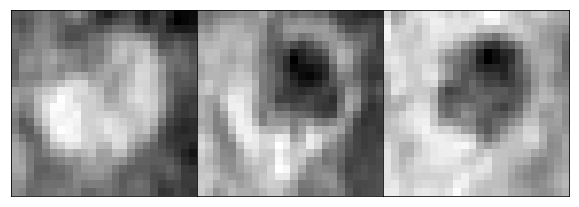

In [1382]:
hf.draw_slices(x)

In [ ]:
sal_map = get_saliency_map(W, test_neurons, num_rel_f)

h_ja = np.zeros((num_rel_f, test_neurons.shape[-1]))
for f_num in range(num_rel_f):
    h_ja[f_num] = conv3_ch_plus[all_features[relevant_features[f_num]]].mean((0,1,2))

contrib_sample[f_num,:,:,:,ch_ix] = test_n_ch = test_neurons

sol = minimize(lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] + w[2]*h_ja[2] - test_n_ch)**2) - .001*(log(w[0]) + log(w[1]) + log(w[2])), [15,1,1],
         bounds = ((0.001, None), (0.001, None), (0.001, None)))
w_a = sol['x']

In [1384]:
h_ja_full = copy.deepcopy(h_ja)

In [1358]:
h_ja = copy.deepcopy(h_ja_full)

In [1385]:
for f_num in range(num_rel_f):
    h_ja[f_num] = w_a[f_num]*h_ja[f_num]
    #h_ja[f_num][h_ja[f_num] < np.median(h_ja[f_num])] = 0
    h_ja[f_num] /= h_ja[f_num][h_ja[f_num] > 0].mean()
for ch_ix in range(test_neurons.shape[-1]):
    h_ja[:, ch_ix][h_ja[:, ch_ix] != np.max(h_ja[:, ch_ix])] = 0

In [1386]:
gauss = np.zeros((12,12))

for i in range(gauss.shape[0]):
    for j in range(gauss.shape[1]):
        dx = abs(i - gauss.shape[0]/2+.5)
        dy = abs(j - gauss.shape[1]/2+.5)
        gauss[i,j] = scipy.stats.norm.pdf((dx**2 + dy**2)**.5, 0, gauss.shape[0]//3)
gauss = np.transpose(np.tile(gauss, (6,1,1)), (1,2,0))

In [1387]:
w_a = w_a/w_a.mean()

In [1398]:
sal_map = get_saliency_map(W, test_neurons, num_rel_f)
for f_num in range(num_rel_f):
    sal_map[f_num] *= gauss
    sal_map[f_num][sal_map[f_num] < np.median(sal_map[f_num])] = 0
    sal_map[f_num] -= sal_map[f_num].min()
    sal_map[f_num] /= sal_map[f_num].mean()
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] + h_ja[f_num,ch_ix]*5 \
                - h_ja[f_num-1,ch_ix]*sal_map[f_num-1] - h_ja[f_num-2,ch_ix]*sal_map[f_num-2]
contrib_sample[contrib_sample < 0] = 0

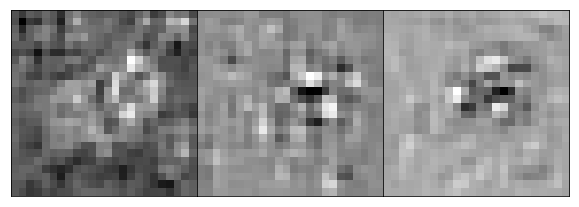

In [1399]:
for f_num in range(num_rel_f):
    #print(all_features[relevant_features[f_num]])
    x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "1f"+all_features[relevant_features[f_num]]+".png"),
                         contrib_sample[f_num], init_img=x, rotate=False, stepsize=.4, num_steps=1)

h_ja = copy.deepcopy(h_ja_full)
for f_num in range(num_rel_f):
    #h_ja[f_num] = w_a[f_num]*h_ja[f_num]
    #h_ja[f_num][h_ja[f_num] < np.median(h_ja[f_num])] = 0
    h_ja[f_num] /= h_ja[f_num][h_ja[f_num] > 0].mean()
for ch_ix in range(test_neurons.shape[-1]):
    h_ja[:, ch_ix][h_ja[:, ch_ix] != np.max(h_ja[:, ch_ix])] = 0
    
f_num = 0
sal_map = get_saliency_map(W, test_neurons, num_rel_f)
sal_map[f_num] *= gauss
sal_map[f_num][sal_map[f_num] < np.median(sal_map[f_num])] = 0
sal_map[f_num] -= sal_map[f_num].min()
sal_map[f_num] /= sal_map[f_num].mean()
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - h_ja[f_num,ch_ix]*sal_map[f_num] \
            + h_ja[f_num-1,ch_ix]*sal_map[f_num-1]/10 + h_ja[f_num-2,ch_ix]*sal_map[f_num-2]/10
contrib_sample[contrib_sample < 0] = 0
print(all_features[relevant_features[f_num]])
x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                     contrib_sample[f_num], init_img=x, rotate=False, stepsize=.1, num_steps=1)

In [ ]:
for r in range(4):
    x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                         contrib_sample[f_num], init_img=x, rotate=False, stepsize=.5, num_steps=1)

In [1287]:
h_ic = [model_conv3_pre.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]
h_ic += [model_conv3_pre.predict(np.expand_dims(np.flipud(np.rot90(x,r)),0))[0] for r in range(4)]
h_ic += [model_conv3_pre.predict(np.expand_dims(np.fliplr(np.rot90(x,r)),0))[0] for r in range(4)]

for r in range(len(h_ic)):
    h_ic[r][h_ic[r] < 0] = 0

h_ic_rot = [np.rot90(h_ic[r], 4-r) for r in range(4)] #rotated back into original frame
h_ic_rot += [np.rot90(np.flipud(h_ic[r]), 4-r) for r in range(4,8)]
h_ic_rot += [np.rot90(np.fliplr(h_ic[r]), 4-r) for r in range(8,12)]

h_ic_rot = np.array(h_ic_rot)

progressive uniform enhancement (crc)


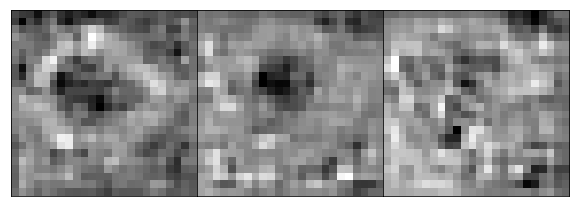

In [1295]:
x_est=[]
for r in range(12):
    test_neurons = h_ic_rot[r]
    sal_map = get_saliency_map(W, test_neurons, num_rel_f)

    z_actual = model_conv3_input.predict(np.expand_dims(test_neurons,0))[0] - z_bias

    h_ja = np.zeros((num_rel_f, test_neurons.shape[-1]))
    for f_num in range(num_rel_f):
        h_ja[f_num] = conv3_ch_plus[all_features[relevant_features[f_num]]].mean((0,1,2))

    test_n_ch = test_neurons.mean((0,1,2))

    sol = minimize(lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] + w[2]*h_ja[2] - test_n_ch)**2) - .001*(log(w[0]) + log(w[1]) + log(w[2])), [15,1,1],
             bounds = ((0.001, None), (0.001, None), (0.001, None)))
    w_a = sol['x']

    for f_num in range(num_rel_f):
        #h_ja[f_num] = w_a[f_num]*h_ja[f_num]
        #h_ja[f_num][h_ja[f_num] < np.median(h_ja[f_num])] = 0
        h_ja[f_num] /= h_ja[f_num][h_ja[f_num] > 0].mean()
    for ch_ix in range(test_neurons.shape[-1]):
        h_ja[:, ch_ix][h_ja[:, ch_ix] != np.max(h_ja[:, ch_ix])] = 0

    contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
    
    #for f_num in range(num_rel_f):
    f_num = 0
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]

    sal_map = get_saliency_map(W, test_neurons, num_rel_f)
    sal_map[f_num] *= gauss
    sal_map[f_num][sal_map[f_num] < np.median(sal_map[f_num])] = 0
    sal_map[f_num] -= sal_map[f_num].min()
    sal_map[f_num] /= sal_map[f_num].mean()
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - h_ja[f_num,ch_ix]*sal_map[f_num] \
                + h_ja[f_num-1,ch_ix]*sal_map[f_num-1] + h_ja[f_num-2,ch_ix]*sal_map[f_num-2]
    contrib_sample[contrib_sample < 0] = 0
    x_est.append(cnna.visualize_activations(model_conv3_pre, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                         contrib_sample[f_num], init_img=x, rotate=False, stepsize=.1, num_steps=1))
print(all_features[relevant_features[f_num]])

In [1302]:
x_est_avg = np.min(np.array(x_est),0)

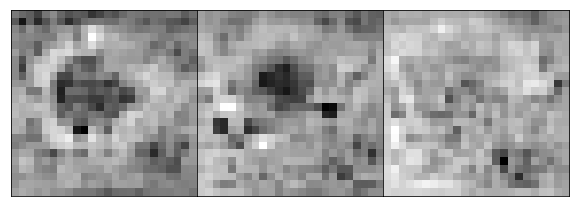

In [1303]:
hf.draw_slices(x_est_avg)

In [989]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

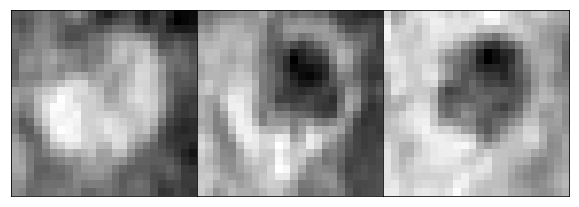

In [1395]:
f_num = 0
x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "test.png"),
                     test_neurons, init_img=x, rotate=False, stepsize=.01, num_steps=100)

In [ ]:
contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
for f_num in range(num_rel_f):
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]

In [5]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
fig = cnna.tsne(filters_by_cls)
fig.show()

In [224]:
len(hf.flatten([list(feature_sheet["evidence1"+cls].dropna().values) for cls in C.classes_to_include]))

137

model_conv1 = cbuild.build_pretrain_model(model, last_layer=-6, add_activ=True)
model_conv2 = cbuild.build_pretrain_model(model, last_layer=-5, add_activ=True)
model_conv3 = cbuild.build_pretrain_model(model, last_layer=-4, add_activ=True)
model_dense = cbuild.build_pretrain_model(model, last_layer=-3, add_activ=True)

cls = 'cyst'
cls_img_set = orig_data_dict[cls][0]
cls_activ_set = model_conv3.predict(cls_img_set)

nmf = NMF(4)
cls_activ_set_xform = nmf.fit_transform(cls_activ_set.mean((1,2,3)))

nmf_comps = [nmf.components_[i] * (nmf.components_[i] > np.median(nmf.components_,0)*2) for i in range(4)]

In [187]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [ ]:
cnna.visualize_layer_weighted(model_frozen, 'conv3d_11', "D:\\filters", K.constant(nmf_comps[0]))

In [277]:
activs0 = cls_activ_set[:,:,:,:,nmf_comps[1] > 0]
activ_map0 = activs0.mean(4)

In [278]:
activ_map0, _ = tr.rescale_img(np.transpose(activ_map0, (1,2,3,0)), cls_img_set[img_id].shape[:3])
activ_map0 = np.transpose(activ_map0, (3,0,1,2))

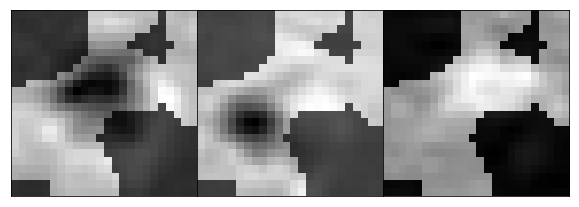

In [282]:
img_id = 1
alpha = 1.
overlaid_img = cls_img_set[img_id] - np.amin(cls_img_set[img_id])
overlaid_img = np.stack([((activ_map0[img_id] > np.mean(activ_map0[img_id])*alpha)+.5) * overlaid_img[:,:,:,i] for i in range(3)], 3)
hf.draw_slices(overlaid_img)

In [ ]:
hf.draw_slices(cls_img_set[img_id])

In [596]:
dw = np.linspace(0,5,100)
dy = np.empty((num_rel_f, len(dw)))
w_f = np.empty(num_rel_f)

for f_num in range(num_rel_f):
    for w_ix in range(len(dw)):
        z_f = model_conv3_input.predict(np.expand_dims(test_neurons - dw[w_ix]*contrib_sample[f_num],0))[0]
        dy[f_num,w_ix] = z_f[1] - np.amax(z_f[[0,2,3,4,5]])
    #w_f[f_num] = (dy[f_num] < 0).nonzero()[0][0]

In [464]:
z_f[:1]+z_f[2:]

array([  0.12477922, -13.959014  , -11.985743  , -11.229456  ],
      dtype=float32)

In [ ]:
f_num = 2
[dy[f_num][i] - dy[f_num][i-1] for i in range(1,len(dy[f_num]))]

In [ ]:
dy[0]

26

In [361]:
sal_map = get_saliency_map(W, test_neurons, num_rel_f)
z_f = np.empty((num_rel_f, 6))
for f_num in range(num_rel_f):
    contrib_sample = np.transpose(np.tile(sal_map[f_num], (128,1,1,1)), (1,2,3,0)) + test_neurons
    #print(all_features[relevant_features[f_num]])
    z_f[f_num] = model_conv3_input.predict(np.expand_dims(contrib_sample,0)) - z_actual

In [388]:
noise = np.random.normal(size=(1000,*test_neurons.shape))

In [389]:
z_base = model_conv3_input.predict(noise)

In [366]:
z_base = model_conv3_input.predict(np.expand_dims(np.ones(test_neurons.shape),0))

In [397]:
z_base = z_base.mean(0)

In [398]:
Z = np.concatenate((z_f, np.expand_dims(z_base,0)))

In [400]:
W = Z.shape

(4, 6)

In [362]:
z_f

array([[-3.15560436,  0.9448576 , -1.96781707, -0.67129517, -2.05151415,
         2.70983791],
       [-1.69611597, -0.05921125, -1.89745355,  0.80170631, -2.63591051,
         1.83641386],
       [-1.55328608,  0.75187254, -1.75524974, -0.0799427 , -1.24825335,
         1.33727264]])

In [ ]:
model_conv3_input.predict(np.expand_dims(test_neurons,0))

In [318]:
C.classes_to_include

['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']